In [ ]:
pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.7 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [ ]:
# We create our device (ideal simulator -> zero noise, infinite shots)
dev = qml.device("default.qubit")

In [ ]:
def S(x):
  """
    Encode classical data with a unitary operation.

    This is a PQC with 2 qubits:
      - Encode by rotating around Y for qubit 1 (feature 1).
      - Encode by rotating around Y for qubit 2 (feature 2).
      - We also add an entangling layer, which is a nonclassical operation, natural to quantum computers.
  """

  qml.RY(x[0], wires=0)

  qml.CNOT(wires=[0, 1])

  qml.RY(x[1], wires=1)

  qml.CNOT(wires=[0, 1])

In [ ]:
def W(layer_weights):
    """
    Parameterized trainable layer.

    2-D Numpy Array: numpy.Array([[0.1, 1.57, 0.9],
                                  [0.4, 1.2, 0.3]])
    """
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])


@qml.qnode(dev)
def circuit(weights, x):
    S(x)

    for layer_weights in weights:
        # S(x)
        W(layer_weights)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias


def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)


def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)


def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [ ]:
data = np.loadtxt("data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First training sample: {X[0]}")

normalization = np.sqrt(np.sum(X**2, -1))
features = (X.T / normalization).T
print(f"First training sample - normalized: {features[0]}")


Y = data[:, -1]

Primeira amostra de treino: [0.4  0.75]
Primeira amostra de treino normalizada: [0.47058824 0.88235294]


In [ ]:
normalization = np.sqrt(np.sum(X**2, -1))
features = (X.T / normalization).T
# features = X

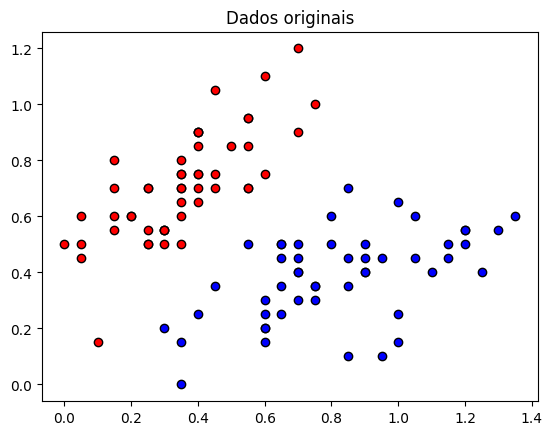

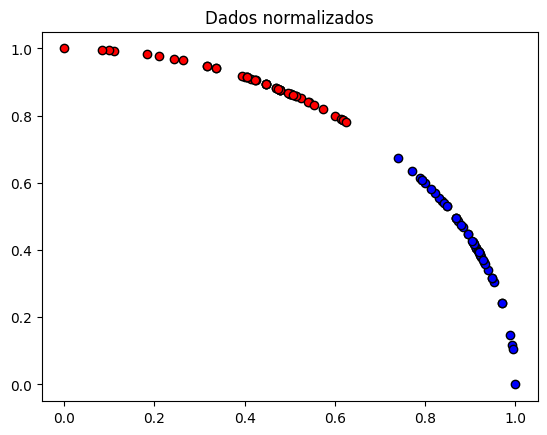

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Normalized data")
plt.show()

In [ ]:
np.random.seed(42)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [ ]:
num_qubits = 2
num_layers = 10

np.random.seed(42)
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [ ]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 32

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.7987428 | Acc train: 0.4533333 | Acc validation: 0.6400000
Iter:     4 | Cost: 1.6743119 | Acc train: 0.4533333 | Acc validation: 0.6400000
Iter:     6 | Cost: 1.5370274 | Acc train: 0.4533333 | Acc validation: 0.6400000
Iter:     8 | Cost: 1.4313671 | Acc train: 0.0533333 | Acc validation: 0.0800000
Iter:    10 | Cost: 1.3760675 | Acc train: 0.0933333 | Acc validation: 0.0800000
Iter:    12 | Cost: 1.3493889 | Acc train: 0.5466667 | Acc validation: 0.3600000
Iter:    14 | Cost: 1.2622883 | Acc train: 0.5466667 | Acc validation: 0.3600000
Iter:    16 | Cost: 1.0778578 | Acc train: 0.5466667 | Acc validation: 0.3600000
Iter:    18 | Cost: 0.9318874 | Acc train: 0.5466667 | Acc validation: 0.3600000
Iter:    20 | Cost: 0.8225482 | Acc train: 0.5466667 | Acc validation: 0.3600000
Iter:    22 | Cost: 0.7323506 | Acc train: 0.8266667 | Acc validation: 0.7600000
Iter:    24 | Cost: 0.6586650 | Acc train: 0.9866667 | Acc validation: 0.9600000
Iter:    26 | Cost: 0.621295

/usr/local/lib/python3.10/dist-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


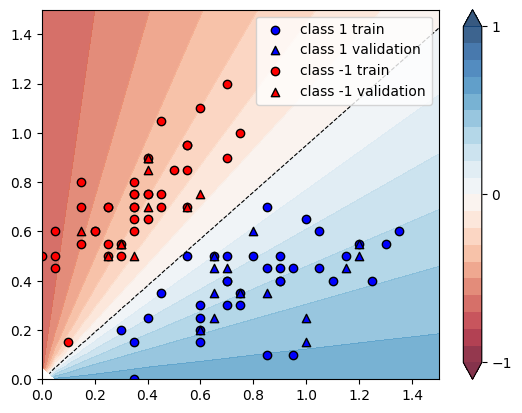

In [ ]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = X_grid  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()